# Mortalidad cardiovascular y contaminacion del aire.

In [2]:
suppressPackageStartupMessages({
  library(astsa)
  library(tsibble)
  library(dplyr)
  library(purrr)
  library(broom)
  library(tidyr)
  library(ggplot2)
})

In [7]:
df_ts_tidy <- ts(cbind(part, tempr, cmort),
    start=start(part),
    frequency = frequency(part)) |>
  as_tsibble(key=index) |>
	mutate(key=recode(key, 
    `tempr`="Temperatura",
    `cmort`="Mortalidad",
    `part`="Particulas")
  )

Warning message:
“Expected frequency of weekly data: 365.25 / 7 (approx 52.18), not  52.”


Los datos que se muestran son series extraídas de un estudio de Shumway _et al._ de los posibles efectos de la temperatura y la contaminación sobre la mortalidad semanal en el condado de Los Ángeles. Nótense los fuertes componentes estacionales en todas las series, correspondientes a las variaciones invierno-verano; y la tendencia decreciente de la mortalidad cardiovascular en el período de 10 años.

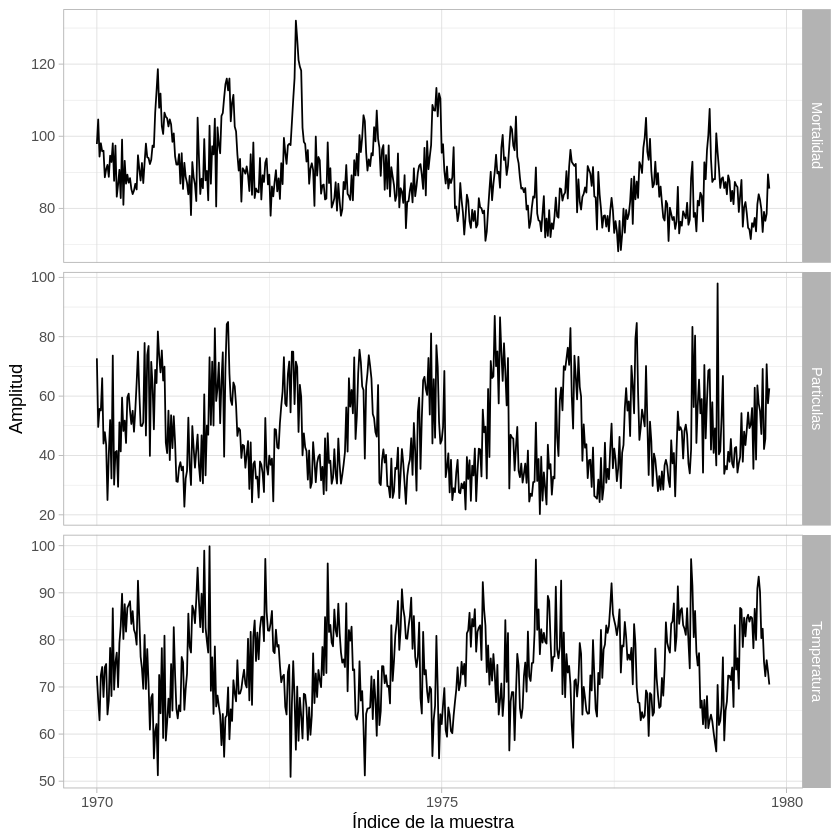

In [8]:
ggplot(df_ts_tidy, aes(x=index, y=value)) +
	geom_line() + 
	facet_grid(rows=vars(key), scales = "free") +
	xlab("Índice de la muestra") + ylab("Amplitud") + 
	theme_light()

Una matriz de diagrama de dispersión, que se muestra en la figura \@ref(fig:pairs-plot), indica una posible relación lineal entre la mortalidad y las partículas contaminantes y una posible relación con la temperatura. Tenga en cuenta la forma curvilínea de la curva de mortalidad por temperatura, lo que indica que las temperaturas más altas, así como las temperaturas más bajas, están asociadas con aumentos en la mortalidad cardiovascular.

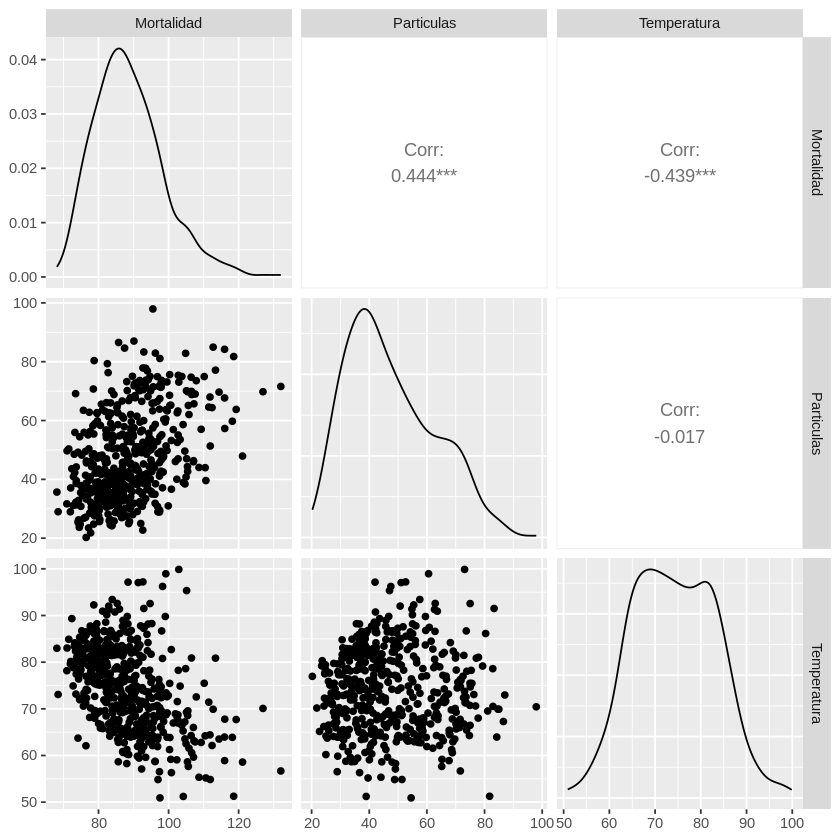

In [11]:
df_ts_tidy |>
  tidyr::spread(key = "key", value = "value") |>
  GGally::ggpairs(2:4)

Con base en la matriz de diagramas de dispersión, consideramos, tentativamente, cuatro modelos donde $M_t$ denota mortalidad cardiovascular, $T_t$ denota temperatura y $P_t$ denota los niveles de partículas. Ellos son:

$$
\begin{aligned}
  Mt &= \beta_0 + \beta_1t + w_t \\
  Mt &= \beta_0 + \beta_1t + \beta_2(T_t − T_{.}) + w_t \\
  Mt &= \beta_0 + \beta_1t + \beta_2(T_t − T_{.}) + \beta_3(T_t − T_{.})^2 + w_t \\
  Mt &= \beta_0 + \beta_1t + \beta_2(T_t − T_{.}) + \beta_3(T_t − T_{.})^2 + \beta_4P_t + w_t
\end{aligned}
$$

donde ajustamos la temperatura por su media, $T_{.} = 74{,}26$, para evitar problemas de colinealidad.

In [12]:
df_ts_tidy <- df_ts_tidy %>%
	spread(key = "key", value = "value") %>%
	mutate(trend = time(cmort), 
		diff_Temp = Temperatura - mean(Temperatura),
		diff_Temp_Square = diff_Temp ** 2)

In [13]:
fitted_models <- tibble(models =
	c(Mortalidad ~ trend, 
		Mortalidad ~ trend + diff_Temp, 
		Mortalidad ~ trend + diff_Temp + diff_Temp_Square, 
		Mortalidad ~ trend + diff_Temp + diff_Temp_Square + Particulas)) %>%
	mutate(fit=map(models, ~lm(., data=df_ts_tidy)),
		glanced = map(fit, glance)) %>%
  unnest(glanced)

fitted_models %>%
	mutate(SSE=sigma ** 2 * df.residual, MSE=sigma ** 2) %>%
	select(SSE, df.residual, MSE, adj.r.squared, AIC, BIC) %>%
	mutate(AIC=AIC / nrow(df_ts_tidy) - log(2*pi), BIC=BIC / nrow(df_ts_tidy) - log(2*pi)) %>%
	tibble::add_column(Model=c("$M_t = \\beta_0 + \\beta_1 t + w_t$",
		"$M_t = \\beta_0 + \\beta_1 t + \\beta_2(T - T_\\dot) + w_t$", 
		"$M_t = \\beta_0 + \\beta_1 t + \\beta_2(T - T_\\dot) + \\beta_3(T - T_\\dot)^2 + w_t$", 
		"$M_t = \\beta_0 + \\beta_1 t + \\beta_2(T - T_\\dot) + \\beta_3(T - T_\\dot)^2 + \\beta_4 P_t + w_t$"), .before=1)

Model,SSE,df.residual,MSE,adj.r.squared,AIC,BIC
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
$M_t = \beta_0 + \beta_1 t + w_t$,40019.84,506,79.09059,0.2088866,5.378460,5.403443
$M_t = \beta_0 + \beta_1 t + \beta_2(T - T_\dot) + w_t$,31413.21,505,62.20438,0.3777930,5.140250,5.173561
$M_t = \beta_0 + \beta_1 t + \beta_2(T - T_\dot) + \beta_3(T - T_\dot)^2 + w_t$,27984.53,504,55.52486,0.4446057,5.028611,5.070249
$M_t = \beta_0 + \beta_1 t + \beta_2(T - T_\dot) + \beta_3(T - T_\dot)^2 + \beta_4 P_t + w_t$,20508.44,503,40.77225,0.5921705,4.721732,4.771699


Notamos que cada modelo funciona sustancialmente mejor que el anterior y que el modelo que incluye la temperatura, la temperatura al cuadrado y las partículas funciona mejor, representando alrededor del 60% de la variabilidad y con el mejor valor para AIC y BIC.

In [15]:
coef_matrix <- summary(fitted_models$fit[[4]])
coef_matrix


Call:
lm(formula = ., data = df_ts_tidy)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.0760  -4.2153  -0.4878   3.7435  29.2448 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.831e+03  1.996e+02   14.19  < 2e-16 ***
trend            -1.396e+00  1.010e-01  -13.82  < 2e-16 ***
diff_Temp        -4.725e-01  3.162e-02  -14.94  < 2e-16 ***
diff_Temp_Square  2.259e-02  2.827e-03    7.99 9.26e-15 ***
Particulas        2.554e-01  1.886e-02   13.54  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.385 on 503 degrees of freedom
Multiple R-squared:  0.5954,	Adjusted R-squared:  0.5922 
F-statistic:   185 on 4 and 503 DF,  p-value: < 2.2e-16


El mejor modelo que se selecciona es entonces: 

$$Mt = 2831{,}49_{(0{,}01996)} - 1{,}396_{(0{,}1010)}t - 0{,}4725_{(0{,}0316)}(T_t − T_{.}) + 0{,}0226_{(0{,}0028)}(T_t − T_{.})^2 + 0{,}2554_{(0{,}0189)}P_t + w_t$$

para mortalidad. Como era de esperar, se presenta una tendencia negativa en el tiempo, así como un coeficiente negativo para la temperatura ajustada. La contaminación tiene un peso positivo y puede interpretarse como la contribución incremental a las muertes diarias por unidad de contaminación por partículas.

Al verificar los residuales, se puede observar un comportamiento violento alrededor del cero, pero que parece variar por encima y debajo de este con regularidad. Esto implica que existe autocorrelación residual que no se ha tomado en cuenta en el modelo de regresión.

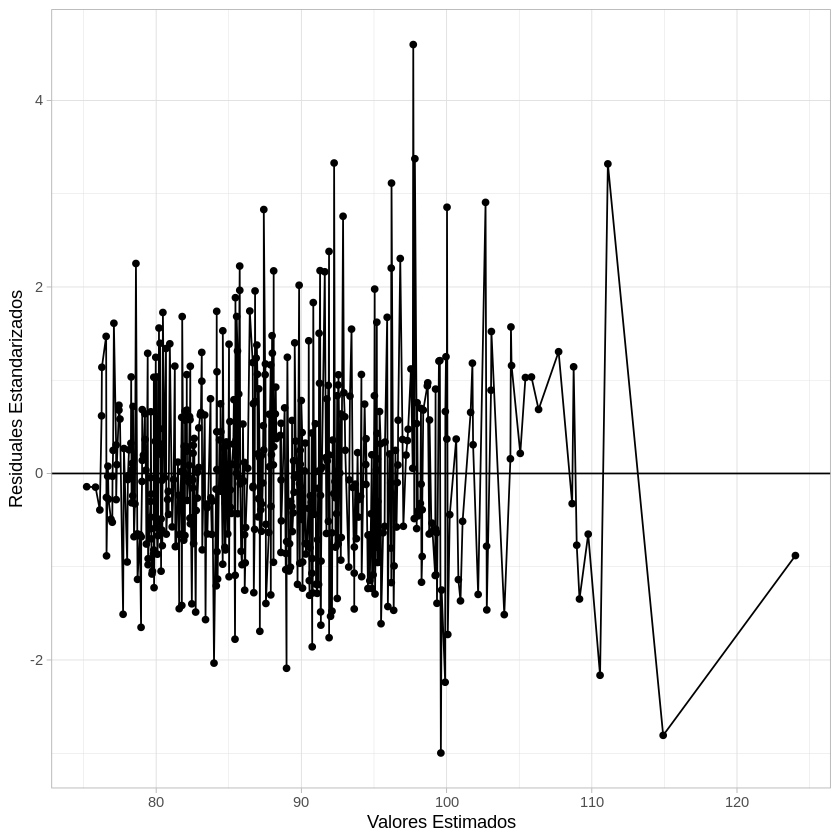

In [16]:
augmented_df <- augment(fitted_models$fit[[4]])

ggplot(augmented_df[, c(".fitted", ".std.resid")], 
  aes(x=.fitted, y=.std.resid)) +
  geom_line() + geom_point() +
  geom_hline(yintercept=0) +
  xlab("Valores Estimados") +
  ylab("Residuales Estandarizados") + 
  theme_light()

Una mirada a la función de autocorrelación y la función de autocorrelación parcial muestra que las observaciones en la serie tienen correlación con otras observaciones adyacentes, y que un modelo autoregresivo parece que seria mas apropiado. 

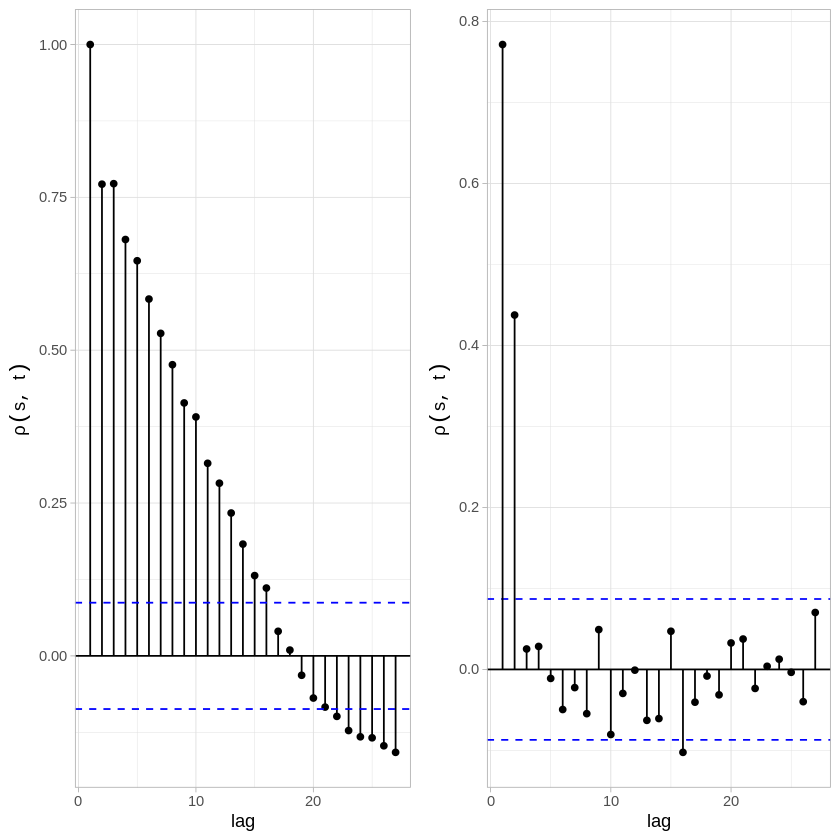

In [17]:
# Se calculan las correlaciones y correlaciones parciales
df_values <- data.frame(lag=1:27, 
	acf_vals=acf(augmented_df$Mortalidad, plot=FALSE)$acf[,,1][1:27],
	pacf_vals=pacf(augmented_df$Mortalidad, plot=FALSE)$acf[,,1])

cowplot::plot_grid(
	ggplot(data = df_values, mapping = aes(x = lag, y = acf_vals)) +
	  geom_point() +
	  geom_hline(aes(yintercept = 0)) +
	  geom_segment(mapping = aes(xend = lag, yend = 0)) +
	  geom_hline(yintercept = c(1.96/sqrt(nrow(df_ts_tidy)), -1.96/sqrt(nrow(df_ts_tidy))), linetype=2, color='blue') +
	  ylab(latex2exp::TeX("$\\rho(s, t)$")) +
	  theme_light(), 
  ggplot(data = df_values, mapping = aes(x = lag, y = pacf_vals)) +
	  geom_point() +
	  geom_hline(aes(yintercept = 0)) +
	  geom_hline(yintercept = c(1.96/sqrt(nrow(df_ts_tidy)), -1.96/sqrt(nrow(df_ts_tidy))), linetype=2, color='blue') +
	  geom_segment(mapping = aes(xend = lag, yend = 0)) +
	  ylab(latex2exp::TeX("$\\rho(s, t)$")) +
	  theme_light(), 
	nrow=1)